# Imports

In [1]:
import os
from copy import deepcopy
from pathlib import Path
from typing import Tuple

import holoviews as hv
import hvplot.pandas
import joblib
import numpy as np
import pandas as pd
import panel as pn
from extract_features import load_and_process_sample, process_dataset
from imu_pipeline import IMUPipeline
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    auc,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
)
from sklearn.model_selection import cross_val_score, train_test_split
from visualization import signal_viewer

pn.extension("bokeh")
hv.extension("bokeh")

# Functions

## Plot feature importance

In [2]:
def plot_feature_importance(model: RandomForestClassifier):
    """
    Plot feature importances from a fitted RandomForestClassifier using hvPlot.

    Parameters
    ----------
    model : RandomForestClassifier
        A trained classifier with `feature_importances_` and `feature_names_in_` attributes.

    Returns
    -------
    hv.Chart
        A bar chart showing sorted feature importances.
    """

    importances = pd.Series(model.feature_importances_, index=model.feature_names_in_)
    importances = importances.sort_values(ascending=True)
    plot = (
        importances.to_frame()
        .reset_index()
        .rename(columns={0: "imp_val"})
        .hvplot.bar(x="index", y="imp_val")
        .opts(width=900, ylabel="Importance", xrotation=70)
    )
    return plot


## Get clasification reports/plots

In [3]:
def plot_model_eval(
    y_true: pd.Series, y_pred: pd.Series, probs: np.ndarray
) -> Tuple[str, ConfusionMatrixDisplay, hv.Overlay]:
    """
    Evaluate a classification model and return key performance metrics and visualizations.

    Parameters
    ----------
    y_true : pd.Series
        True class labels.
    y_pred : pd.Series
        Predicted class labels.
    probs : np.ndarray
        Predicted class probabilities, with shape (n_samples, 2), where each column corresponds
        to the probability of a class (assumed order: ["collision", "normal"]).

    Returns
    -------
    report : str
        Text report of precision, recall, f1-score, and support per class.
    plot_cm : ConfusionMatrixDisplay
        Confusion matrix visualization.
    plot_pr : hv.Overlay
        Precision-recall curve overlay for each class.
    """

    report = classification_report(y_true=y_true, y_pred=y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=["collision", "normal"])
    plot_cm = ConfusionMatrixDisplay(cm, display_labels=["collision", "normal"])

    return report, plot_cm

## Plot features histograms

In [4]:
def train_test_inf_feature_viewer(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    df_inf: pd.DataFrame,
    model: RandomForestClassifier,
) -> pn.Column:
    """
    Create an interactive histogram viewer for feature distributions across
    train, test, and inference datasets.

    Parameters
    ----------
    df_train : pd.DataFrame
        Training dataset containing feature columns.
    df_test : pd.DataFrame
        Test dataset containing feature columns.
    df_inf : pd.DataFrame
        Inference dataset containing feature columns.
    model : RandomForestClassifier
        Trained model with `feature_names_in_` attribute specifying feature names.

    Returns
    -------
    pn.Column
        A Panel layout with a feature selector and dynamic histogram plots
        for train, test, and inference distributions of the selected feature.
    """

    feature_names = model.model.feature_names_in_.tolist()

    feature_selector = pn.widgets.Select(name="Feature", options=feature_names)

    @pn.depends(feature_selector)
    def _plot(feature_selector_val):

        xlim_min = np.min(
            np.array(
                (
                    df_train[feature_selector_val].min(),
                    df_test[feature_selector_val].min(),
                    df_inf[feature_selector_val].min(),
                )
            )
        )

        xlim_max = np.max(
            np.array(
                (
                    df_train[feature_selector_val].max(),
                    df_test[feature_selector_val].max(),
                    df_inf[feature_selector_val].max(),
                )
            )
        )

        hist_train = df_train.hvplot.hist(
            y=feature_selector_val,
            bins=50,
            xlim=(xlim_min, xlim_max),
            title=f"Train -> Feature: {feature_selector_val}, min/max:{float(round(df_train[feature_selector_val].min(),2)), float(round(df_train[feature_selector_val].max(),2))}",
        )
        hist_test = df_test.hvplot.hist(
            y=feature_selector_val,
            bins=50,
            xlim=(xlim_min, xlim_max),
            title=f"Test -> Feature: {feature_selector_val}, min/max:{float(round(df_test[feature_selector_val].min(),2)), float(round(df_test[feature_selector_val].max(),2))}",
        )
        hist_inf = df_inf.hvplot.hist(
            y=feature_selector_val,
            bins=50,
            xlim=(xlim_min, xlim_max),
            title=f"Inference -> Feature: {feature_selector_val}, min/max:{float(round(df_inf[feature_selector_val].min(),2)), float(round(df_inf[feature_selector_val].max(),2))}",
        )

        return pn.Column(hist_train, hist_test, hist_inf)

    return pn.Column(feature_selector, _plot)

## Get summary table for features

In [5]:
def get_summary_table(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """
    Compute summary statistics for selected columns in a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing numerical data.
    columns : list of str
        List of column names to compute statistics for.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing summary statistics (mean, median, min, max,
        data range, standard deviation, and variance) for each selected column.
    """

    def data_range(x):
        return x.max() - x.min()

    df_agg = (
        df[columns].agg(["mean", "median", "min", "max", data_range, "std", "var"]).T
    )
    df_agg.reset_index(inplace=True)
    return df_agg

def get_summary_mutliple_table(tables: dict, columns: list[str]) -> pd.DataFrame:
    """
    Generate summary statistics for multiple DataFrames and combine them into a single table.

    Parameters
    ----------
    tables : dict
        Dictionary where keys are dataset names and values are pandas DataFrames.
    columns : list of str
        List of column names to include in the summary statistics.

    Returns
    -------
    pd.DataFrame
        A multi-column DataFrame containing summary statistics (mean, median, min,
        max, data range, std, var) for each dataset, indexed by the specified columns.
    """
    summary_dict = {}

    for name, df in tables.items():
        summary_df = get_summary_table(df, columns)
        summary_df.columns = pd.MultiIndex.from_tuples(
            [(stat, name) for stat in summary_df.columns]
        )
        summary_dict[name] = summary_df

    combined = pd.concat(summary_dict.values(), axis=1)
    combined = combined.sort_index(axis=1, level=[0, 1])

    stat_order = ["index", "mean", "median", "min", "max", "data_range", "std", "var"]
    combined = combined[
        sorted(combined.columns, key=lambda x: (stat_order.index(x[0]), x[1]))
    ]

    combined = (
        combined.set_index("index")
        .reset_index()
        .drop(columns=["index"])
        .set_index(columns)
    )

    return combined

## Plot barplots of aggregated feature values

In [6]:
def plot_stats_bars(df_summary: pd.DataFrame) -> pn.Column:
    """
    Create an interactive bar plot to visualize aggregated statistics
    across multiple datasets for selected features.

    Parameters
    ----------
    df_summary : pd.DataFrame
        A multi-index DataFrame containing summary statistics per feature and dataset,
        with column MultiIndex of the form (statistic, dataset_name) and feature names
        as the index.

    Returns
    -------
    pn.Column
        A Panel layout containing interactive widgets for selecting a feature and a
        statistic, along with the corresponding bar plot displaying the selected
        aggregated statistic for that feature across datasets.
    """

    df_summary_flatten = df_summary.copy()
    df_summary_flatten.columns = [
        f"{stat}_{table}" for stat, table in df_summary_flatten.columns
    ]
    df_summary_flatten = df_summary_flatten.reset_index().set_index("index")

    df_summary_flatten_tmp = df_summary_flatten.copy()

    df_summary_flatten_tmp = df_summary_flatten_tmp.reset_index()
    df_summary_flatten_tmp[["axis", "type"]] = df_summary_flatten_tmp[
        "index"
    ].str.extract(r"^(xy|xz|yz|x|y|z|mag)_(.+)$")

    df_summary_flatten_tmp["axis"] = df_summary_flatten_tmp["axis"].fillna("other")
    df_summary_flatten_tmp["type"] = df_summary_flatten_tmp["type"].fillna(
        df_summary_flatten_tmp["index"]
    )
    df_summary_flatten_tmp = df_summary_flatten_tmp.set_index("index")

    feature_names = df_summary_flatten_tmp["type"].unique().tolist()

    stats_name = set(col.split("_")[0] for col in df_summary_flatten.columns)
    stats_name = list(
        {item + "_range" if item == "data" else item for item in stats_name}
    )

    stats_selector = pn.widgets.Select(name="Aggergated Stats:", options=stats_name)
    feature_selector = pn.widgets.Select(
        name="Feature from datasets:", options=feature_names
    )

    @pn.depends(feature_selector, stats_selector)
    def _plot(feature_selector_val, stats_selector_val):

        _df_summary_flatten_tmp = (
            df_summary_flatten_tmp[
                (df_summary_flatten_tmp["type"] == feature_selector_val)
                & (df_summary_flatten_tmp["axis"].isin(["x", "y", "z"]))
            ]
            .filter(regex=stats_selector_val)
            .T
        )

        _df_summary_flatten_tmp = (
            _df_summary_flatten_tmp.reset_index()
            .rename(columns={"index": "stats"})
            .reset_index(drop=True)
            .set_index("stats")
        )
        _df_summary_flatten_tmp.index.name = "statistic"

        return _df_summary_flatten_tmp.hvplot.bar().opts(
            ylabel=stats_selector_val,
            xlabel="Features in df",
            width=900,
            height=400,
            title=f"Aggregated stats from the entire df's: selected feature: {feature_selector_val}, aggregator: {stats_selector_val}",
        )

    return pn.Column(feature_selector, stats_selector, _plot)


## Domain classifer to detect data drift

In [7]:
def domain_classifer(
    df_train: pd.DataFrame, df_inf: pd.DataFrame, features: list[str]
) -> str:
    """
    Detect distribution drift between training and inference datasets using a
    Random Forest classifier to distinguish their feature distributions.

    Parameters
    ----------
    df_train : pd.DataFrame
        Training dataset containing the specified features.

    df_inf : pd.DataFrame
        Inference dataset containing the specified features.

    features : list of str
        List of feature column names to use for drift detection.

    Returns
    -------
    None
        Prints the mean cross-validated AUC/accuracy score indicating drift level.
        Higher scores suggest greater drift between training and inference data.
    """

    _df_train = df_train[features].copy()
    _df_train["label"] = 0

    _df_inf = df_inf[features].copy()
    _df_inf["label"] = 1

    df_both = pd.concat([_df_train, _df_inf], ignore_index=True)

    model = RandomForestClassifier()
    score = cross_val_score(
        model, df_both.drop(columns="label"), df_both["label"], cv=5
    ).mean()
    return print(f"Drift detection AUC/accuracy: {round(score,3)}")


## Custom scaler 

In [8]:
def custom_scaler(unscaled_col: pd.Series, scaled_col: pd.Series) -> pd.Series:
    """
    Scale an unscaled pandas Series to the value range of a reference scaled Series.

    Parameters
    ----------
    unscaled_col : pd.Series
        The data series to be scaled.

    scaled_col : pd.Series
        The reference data series whose min and max define the target scale range.

    Returns
    -------
    pd.Series
        The input series scaled to the range of the reference series.
    """

    df_scaled_new = (
        (unscaled_col - unscaled_col.min()) / (unscaled_col.max() - unscaled_col.min())
    ) * (scaled_col.max() - scaled_col.min()) + scaled_col.min()

    return df_scaled_new


In [9]:
def scale_features_in_df(
    df_unscaled: pd.DataFrame, df_scaled: pd.DataFrame, cols_to_scale: list[str]
) -> pd.DataFrame:
    """
    Scale specified columns in a DataFrame to match the value ranges of a reference DataFrame.

    Parameters
    ----------
    df_unscaled : pd.DataFrame
        DataFrame containing unscaled features.

    df_scaled : pd.DataFrame
        Reference DataFrame with scaled features used to define target value ranges.

    cols_to_scale : list of str
        List of column names to scale using the reference DataFrame.

    Returns
    -------
    pd.DataFrame
        DataFrame with the specified columns scaled to match the reference ranges.
    """

    df_unscaled_tmp = df_unscaled.copy()

    for col in cols_to_scale:
        df_unscaled_tmp[col] = custom_scaler(df_unscaled_tmp[col], df_scaled[col])

    return df_unscaled_tmp

## Histogram Matching

In [10]:
def match_distributions(source: pd.Series, target: pd.Series) -> pd.Series:
    """
    Transform the distribution of the source series to match the distribution of the target series
    using quantile mapping.

    Parameters
    ----------
    source : pd.Series
        Series to be transformed.

    target : pd.Series
        Reference series whose distribution is used for mapping.

    Returns
    -------
    pd.Series
        Transformed series with a distribution approximating that of the target series.
    """

    source = np.asarray(source)
    target = np.asarray(target)

    target_sorted = np.sort(target)

    target_percentiles = np.linspace(0, 1, len(target_sorted))

    target_interp = interp1d(
        target_percentiles, target_sorted, bounds_error=False, fill_value="extrapolate"
    )

    source_ranks = pd.Series(source).rank(pct=True).to_numpy()

    mapped = target_interp(source_ranks)

    return mapped

In [11]:
def match_histogram_in_df(
    df_unscaled: pd.DataFrame, df_scaled: pd.DataFrame, cols_to_scale: list[str]
) -> pd.DataFrame:
    """
    Adjust the distributions of specified columns in an unscaled DataFrame to match
    the distributions of the corresponding columns in a scaled reference DataFrame
    using histogram (quantile) matching.

    Parameters
    ----------
    df_unscaled : pd.DataFrame
        DataFrame containing unscaled feature columns.

    df_scaled : pd.DataFrame
        Reference DataFrame with target feature distributions.

    cols_to_scale : list of str
        List of column names to scale using distribution matching.

    Returns
    -------
    pd.DataFrame
        A copy of the input unscaled DataFrame with selected columns distribution-matched
        to the reference scaled DataFrame.
    """

    df_unscaled_tmp = df_unscaled.copy()

    for col in cols_to_scale:
        df_unscaled_tmp[col] = match_distributions(df_unscaled[col], df_scaled[col])

    return df_unscaled_tmp

## Retrain model

In [12]:
def retrain_model_with_subset(
    df_train: pd.DataFrame,
    df_inf: pd.DataFrame,
    inf_labels: pd.Series,
    model: RandomForestClassifier,
    features: list[str],
    sample_size: float,
) -> Tuple[pd.DataFrame, np.ndarray, RandomForestClassifier]:
    """
    Retrain a RandomForest model by augmenting the training set with a stratified subset
    of labeled inference data, then predict on the remaining inference data.

    Parameters
    ----------
    df_train : pd.DataFrame
        Original training dataset containing features, labels, and sample IDs.

    df_inf : pd.DataFrame
        Inference dataset with features and sample IDs.

    inf_labels : pd.Series
        Series containing labels for the inference dataset, indexed or merged by 'sample_id'.

    model : RandomForestClassifier
        Trained RandomForest model to be deep-copied and retrained.

    features : list of str
        List of feature column names used for training.

    sample_size : float
        Fraction (0 to 1) of inference data to hold out for evaluation.
        The remaining (1 - sample_size) will be used for retraining.

    Returns
    -------
    pd.DataFrame
        The held-out subset of inference data with predictions.

    np.ndarray
        Predicted probabilities for each class in the held-out inference data.

    RandomForestClassifier
        The retrained model.
    """

    _model = deepcopy(model)
    sample_size = 1 - sample_size

    features_n_label = list(features).copy()
    features_n_label.append("label")
    features_n_label.append("sample_id")
    features_n_label.append("sensor_source")

    _df_train = df_train.copy()
    _df_train = df_train[features_n_label]

    _df_inf = df_inf.merge(inf_labels, on="sample_id", how="left")
    _df_inf = _df_inf[features_n_label]
    
    _df_inf["label_x_source"] = _df_inf["label"].astype(str) + "_" + _df_inf["sensor_source"].astype(str)

    _df_inf_sample, _ = train_test_split(
        _df_inf, test_size=sample_size, stratify=_df_inf["label_x_source"], random_state=42
    )

    _df_inf_subset = _df_inf[_df_inf["sample_id"].isin(_df_inf_sample["sample_id"])]
    _df_inf_new_inf = _df_inf[~_df_inf["sample_id"].isin(_df_inf_sample["sample_id"])]

    df_both = pd.concat([_df_train, _df_inf_subset])
    df_both.reset_index(drop=True, inplace=True)

    _model.model.fit(df_both[features], df_both["label"])

    _df_inf_new_inf["pred"] = _model.model.predict(_df_inf_new_inf[features])
    new_probs = _model.model.predict_proba(_df_inf_new_inf[features])

    return _df_inf_new_inf, new_probs, _model


# Viewer

In [13]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

# Model

## Load train/test

In [14]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [15]:
print(f"Train size: {len(df_train)/ (len(df_train) + len(df_test))*100}")
print(f"Test size: {len(df_test)/ (len(df_train) + len(df_test))*100}")

Train size: 80.0
Test size: 20.0


## Load inference

In [16]:
from extract_features import process_dataset
process_dataset('inference')

[INFO] No label CSV found for 'inference' – proceeding without labels.

Processing 'inference' dataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 473/473 [00:01<00:00, 240.58it/s]

Processed 473 samples to data/inference.csv


,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,-2.093650,1.361123,1.952712,-6.589786,8.542498,-0.255506,1.987710,1,623.602573,-1.291725,...,16,37,781,S525962,v1.2.4,ok,80,2.516017,wifi,model_c
1,0.062620,0.145096,0.308158,-0.207827,0.515985,-0.346989,-1.327739,16,2.497417,0.015998,...,28,28,745,S555544,v1.2.3,ok,49,7.589061,wifi,model_b
2,-0.267377,2.245144,10.867668,-6.293573,17.161241,1.190459,5.536484,9,511.216100,-0.279333,...,17,37,399,S696991,v1.3.0,pending,47,6.967340,wifi,model_c
3,1.495145,2.720055,11.703259,-8.711672,20.414931,0.475695,3.091494,16,963.415665,-1.931909,...,32,63,851,S459858,v1.2.4,pending,61,2.879924,5g,model_c
4,0.082381,0.187091,1.076410,-0.247571,1.323981,1.343920,6.447174,12,4.178945,0.011888,...,17,65,674,S905806,v1.2.4,recent,68,5.800120,4g,model_a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,0.109728,0.284275,1.854648,-0.224050,2.078698,3.222860,15.321027,2,9.285258,0.013401,...,14,59,918,S635286,v1.2.4,pending,60,1.005860,wifi,model_a
469,0.182776,2.308840,7.554804,-6.703420,14.258224,0.129065,1.443666,9,536.414840,0.557465,...,10,39,356,S661945,v1.2.3,ok,98,6.602469,5g,model_b
470,1.427000,1.719826,7.482066,-2.440319,9.922385,0.807165,1.516247,20,499.413030,1.563568,...,10,51,843,S814902,v1.3.0,recent,62,1.600064,5g,model_a
471,1.471053,1.514207,8.456269,-2.746464,11.202734,0.802042,4.924809,25,445.682070,1.969005,...,26,30,564,S677928,v1.2.4,pending,97,6.046744,5g,model_c


## Inference labels

In [17]:
labels_inf = pd.read_csv("data/manual_annotation/inference_labels.csv")

## Load df_inf / model / predict / class probabilities

In [18]:
df_inf = pd.read_csv("data/inference.csv")
model = joblib.load("models/imu_pipeline.pkl")

df_inf_preds = model.predict(df_inf)
df_inf_probs = model.predict_proba(df_inf)

## Feature importance

Let’s examine which features are most important for the model.

In [19]:
plot_feature_importance(model.model)

:Bars   [index]   (imp_val)

## Predict on test set

In [20]:
df_test_preds = model.predict(df_test)
df_test_probs = model.predict_proba(df_test)

# EDA

## Test set evaluation

### Model metrics

In [21]:
test_report, cm_test = plot_model_eval(df_test['label'], df_test_preds, df_test_probs)

              precision    recall  f1-score   support

   collision       1.00      0.89      0.94       100
      normal       0.90      1.00      0.95       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200



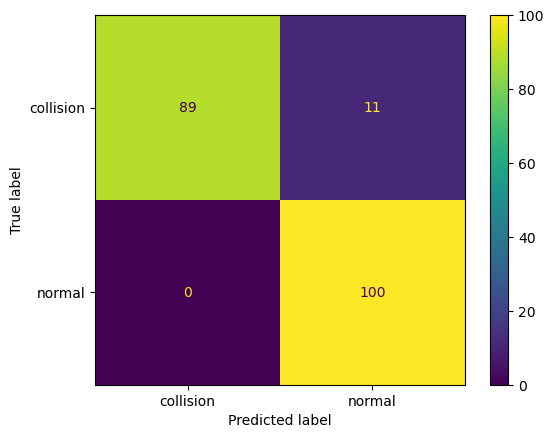

In [22]:
print(test_report)
cm_test.plot()

It seems that the test data shows really good scores and the model deal with the data in a good way

## Inference set evaluation

### Model metrics

In [23]:
inf_report, cm_inf = plot_model_eval(labels_inf['label'], df_inf_preds, df_inf_probs)

              precision    recall  f1-score   support

   collision       0.51      0.83      0.63       236
      normal       0.54      0.20      0.29       237

    accuracy                           0.51       473
   macro avg       0.52      0.51      0.46       473
weighted avg       0.52      0.51      0.46       473



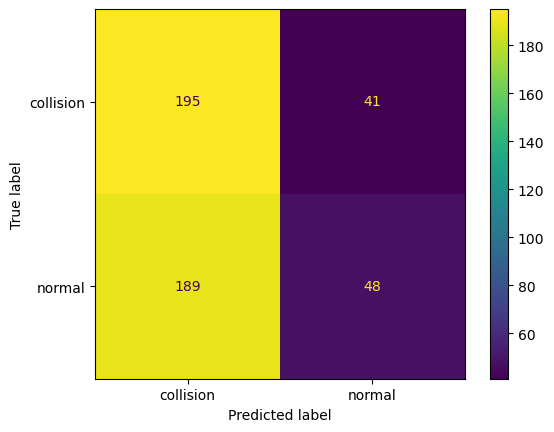

In [24]:
print(inf_report)
cm_inf.plot()

While for the inference data the results are not good

## Viewer for inf data

It seems that the data is very noisey in both of the class's not like in the train data.

In [25]:
signal_viewer(
    data_dir=Path('data/raw/inference'),
    labels_csv=Path('data/manual_annotation/inference_labels.csv')
)

## Singal source

It seems that the inference data has sensor source from phone as well to camera while, train/test were only from camera.

In [26]:
df_train['sensor_source'].value_counts()

sensor_source
camera    800
Name: count, dtype: int64

In [27]:
df_test['sensor_source'].value_counts()

sensor_source
camera    200
Name: count, dtype: int64

In [28]:
df_inf['sensor_source'].value_counts()

sensor_source
phone     309
camera    164
Name: count, dtype: int64

## Datasets analysis / Features analysis

### Model features

In [29]:
features = model.model.feature_names_in_
features

array(['x_mean', 'x_std', 'x_max', 'x_min', 'x_range', 'x_skew',
       'x_kurtosis', 'x_n_peaks', 'x_energy', 'y_mean', 'y_std', 'y_max',
       'y_min', 'y_range', 'y_skew', 'y_kurtosis', 'y_n_peaks',
       'y_energy', 'z_mean', 'z_std', 'z_max', 'z_min', 'z_range',
       'z_skew', 'z_kurtosis', 'z_n_peaks', 'z_energy', 'mag_mean',
       'mag_std', 'mag_max', 'max_delta_mag', 'sudden_change_score',
       'x_fft_max', 'x_fft_mean', 'y_fft_max', 'y_fft_mean', 'z_fft_max',
       'z_fft_mean', 'xy_corr', 'xz_corr', 'yz_corr'], dtype=object)

### Model params

In [30]:
model.model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### Summary tables

Let’s review some statistics of the features across the datasets to understand if there are any scaling patterns.


In [31]:
df_summary = get_summary_mutliple_table({"df_test": df_test,
                                         "df_train": df_train,
                                         "df_inf": df_inf}, features)

df_summary

mean                                 median  \
                           df_inf      df_test     df_train       df_inf   
x_mean                   0.334443     0.072357     0.069947     0.071445   
x_std                    1.473291     0.175786     0.166067     1.851954   
x_max                    5.338022     0.664455     0.556487     6.047633   
x_min                   -4.531746    -0.220048    -0.220334    -4.759934   
x_range                  9.869767     0.884504     0.776821    12.216376   
x_skew                   0.156174     0.559799     0.303161    -0.132100   
x_kurtosis               2.964973     3.202769     1.937158     2.229525   
x_n_peaks               12.953488    12.545000    13.567500    13.000000   
x_energy               403.629173     3.955851     3.483957   435.367857   
y_mean                   0.482968     0.020692     0.022268     0.044132   
y_std                    1.087902     0.160263     0.161828     1.386729   
y_max                    3.958306     0.493159     0.523586     4.407838   
y_min                   -3.007261    -0.288612    -0.287979    -3.147678   
y_range                  6.965566     0.781771     0.811566     8.711909   
y_skew                   0.102853     0.364741     0.429261     0.085263   
y_kurtosis               2.053462     0.949763     1.249954     1.670069   
y_n_peaks               13.114165     4.480000     4.596250     8.000000   
y_energy               287.908905     2.659258     2.727654   262.629063   
z_mean                  10.057672     9.840178     9.840410     9.845513   
z_std                    0.599894     0.054652     0.054150     0.819301   
z_max                   11.787693     9.939156     9.938897    11.703923   
z_min                    8.352620     9.603643     9.607691     8.664765   
z_range                  3.435073     0.335513     0.331206     4.353562   
z_skew                  -0.393806    -1.059559    -1.085238    -0.047529   
z_kurtosis               2.762222     5.123546     5.164430     0.356039   
z_n_peaks               32.471459    32.340000    32.405000    32.000000   
z_energy             10275.442216  9683.292067  9683.735323  9693.615765   
mag_mean                10.380872     9.843549     9.843575     9.852177   
mag_std                  0.724117     0.054330     0.053824     0.934108   
mag_max                 13.052563     9.962553     9.957142    13.485675   
max_delta_mag            3.291816     0.250304     0.248225     3.855703   
sudden_change_score      4.892178     4.050000     3.926250     5.000000   
x_fft_max               68.027978     9.368770     9.142843    51.069153   
x_fft_mean              13.967131     1.092364     0.982066    18.006600   
y_fft_max               77.185222     8.794528     8.667851    44.267954   
y_fft_mean              10.787327     0.881604     0.922535    13.934803   
z_fft_max             1005.767172   984.017783   984.041021   984.551334   
z_fft_mean              25.337286    20.105874    20.103016    26.050121   
xy_corr                  0.063771     0.214421     0.206850     0.074067   
xz_corr                  0.041695     0.112124     0.136329     0.053484   
yz_corr                 -0.155095    -0.378091    -0.394415    -0.109783   

                                                       min               \
                         df_test     df_train       df_inf      df_test   
x_mean                  0.063618     0.063135    -2.379533     0.054032   
x_std                   0.145604     0.145228     0.137185     0.135434   
x_max                   0.287526     0.286315     0.243729     0.243381   
x_min                  -0.219011    -0.217763   -15.242395    -0.263373   
x_range                 0.507897     0.508313     0.458411     0.449476   
x_skew                 -0.352403    -0.359562    -2.554885    -0.495403   
x_kurtosis             -1.243227    -1.247756    -1.419090    -1.426503   
x_n_peaks              15.000000    15.000000     1.000000     1.000000   
x_energy  

### Features histograms

Let’s review it visually using histograms to check for any scale and distribution issues.

In [32]:
train_test_inf_feature_viewer(df_train, df_test, df_inf, model)

Column
    [0] Select(name='Feature', options=['x_mean', 'x_std', ...], value='x_mean')
    [1] ParamFunction(function, _pane=Column, defer_load=False)

### Flatten summary table of several statistics of the features.

In [33]:
df_summary_flatten = df_summary.copy()
df_summary_flatten.columns = [f"{stat}_{table}" for stat, table in df_summary_flatten.columns]
df_summary_flatten = df_summary_flatten.reset_index().set_index('index')

df_summary_flatten

,mean_df_inf,mean_df_test,mean_df_train,median_df_inf,median_df_test,median_df_train,min_df_inf,min_df_test,min_df_train,max_df_inf,...,max_df_train,data_range_df_inf,data_range_df_test,data_range_df_train,std_df_inf,std_df_test,std_df_train,var_df_inf,var_df_test,var_df_train
index,,,,,,,,,,,,,,,,,,,,,
x_mean,0.334443,0.072357,0.069947,0.071445,0.063618,0.063135,-2.379533,0.054032,0.053458,3.306673,...,0.123229,5.686205,0.061513,0.069771,0.863758,0.017860,0.015884,7.460784e-01,0.000319,0.000252
x_std,1.473291,0.175786,0.166067,1.851954,0.145604,0.145228,0.137185,0.135434,0.136440,3.362332,...,0.329744,3.225146,0.193413,0.193304,1.005728,0.055861,0.046038,1.011489e+00,0.003120,0.002120
x_max,5.338022,0.664455,0.556487,6.047633,0.287526,0.286315,0.243729,0.243381,0.242173,20.341059,...,2.225958,20.097330,1.974009,1.983785,3.972661,0.658683,0.559195,1.578203e+01,0.433863,0.312699
x_min,-4.531746,-0.220048,-0.220334,-4.759934,-0.219011,-0.217763,-15.242395,-0.263373,-0.288029,-0.183050,...,-0.179317,15.059346,0.079880,0.108712,3.743591,0.016384,0.018115,1.401447e+01,0.000268,0.000328
x_range,9.869767,0.884504,0.776821,12.216376,0.507897,0.508313,0.458411,0.449476,0.435227,28.703527,...,2.463422,28.245116,1.999933,2.028195,7.180939,0.661643,0.559766,5.156588e+01,0.437772,0.313338
x_skew,0.156174,0.559799,0.303161,-0.132100,-0.352403,-0.359562,-2.554885,-0.495403,-0.504575,3.816361,...,4.341129,6.371246,4.657906,4.845705,1.029517,1.596366,1.374389,1.059905e+00,2.548384,1.888945
x_kurtosis,2.964973,3.202769,1.937158,2.229525,-1.243227,-1.247756,-1.419090,-1.426503,-1.426801,26.845024,...,24.137284,28.264114,24.740970,25.564085,4.485354,7.764374,6.623564,2.011840e+01,60.285503,43.871595
x_n_peaks,12.953488,12.545000,13.567500,13.000000,15.000000,15.000000,1.000000,1.000000,1.000000,35.000000,...,21.000000,34.000000,20.000000,20.000000,6.808982,5.871144,5.052955,4.636224e+01,34.470327,25.532359
x_energy,403.629173,3.955851,3.483957,435.367857,2.503460,2.500523,2.290863,2.230482,2.222015,1583.362159,...,12.226589,1581.071296,9.918633,10.004574,352.366176,2.676421,2.179326,1.241619e+05,7.163228,4.749463


### Plot the bar plot of the summary statistics

Let’s review the aggregated statistics of the features in the form of bar plots.

In [34]:
plot_stats_bars(df_summary)

Column
    [0] Select(name='Feature from datasets:', options=['mean', 'std', ...], value='mean')
    [1] Select(name='Aggergated Stats:', options=['var', 'std', ...], value='var')
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)

### Check for data drift

Let’s check for data drift in the inference set by using pseudo labels for the train and inference data, then training a classifier. Higher AUC values indicate that the model can separate the two datasets well, which suggests a domain drift.

In [35]:
domain_classifer(df_train, df_inf, features)

Drift detection AUC/accuracy: 0.866


## Data corrections

### Scaling the inference data to train feature ranges.

From the previous statistical analysis, we can identify the features that need to be scaled.

In [36]:
not_to_scale_features = ['kurtosis', 'skew', 'peaks', 'sudden_change', 'corr']

cols_to_scale = [col for col in df_inf[features].columns if not any(kw in col for kw in not_to_scale_features)]
cols_to_scale

['x_mean',
 'x_std',
 'x_max',
 'x_min',
 'x_range',
 'x_energy',
 'y_mean',
 'y_std',
 'y_max',
 'y_min',
 'y_range',
 'y_energy',
 'z_mean',
 'z_std',
 'z_max',
 'z_min',
 'z_range',
 'z_energy',
 'mag_mean',
 'mag_std',
 'mag_max',
 'max_delta_mag',
 'x_fft_max',
 'x_fft_mean',
 'y_fft_max',
 'y_fft_mean',
 'z_fft_max',
 'z_fft_mean']

In [37]:
df_inf_scaled = scale_features_in_df(df_inf, df_train, cols_to_scale)

Let’s review the scaled features in the inference dataset compared to the train/test datasets.

In [38]:
train_test_inf_feature_viewer(df_train, df_test, df_inf_scaled, model)

Column
    [0] Select(name='Feature', options=['x_mean', 'x_std', ...], value='x_mean')
    [1] ParamFunction(function, _pane=Column, defer_load=False)

In [39]:
df_inf_scaled_preds = model.predict(df_inf_scaled)
df_inf_scaled_probs = model.predict_proba(df_inf_scaled)

##### Model metrics

In [40]:
inf_scaled_report, cm_inf_scaled = plot_model_eval(labels_inf['label'], df_inf_scaled_preds, df_inf_scaled_probs)

              precision    recall  f1-score   support

   collision       0.50      1.00      0.67       236
      normal       0.00      0.00      0.00       237

    accuracy                           0.50       473
   macro avg       0.25      0.50      0.33       473
weighted avg       0.25      0.50      0.33       473



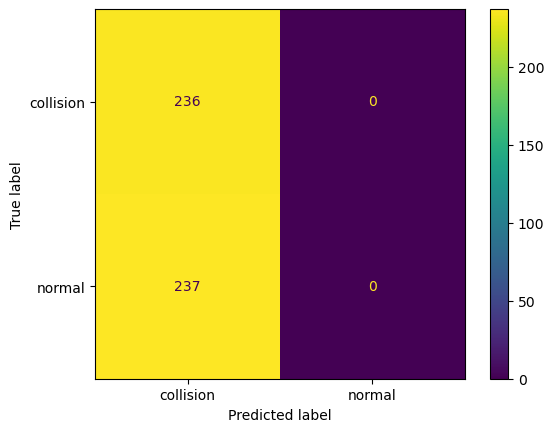

In [41]:
print(inf_scaled_report)
cm_inf_scaled.plot()

### Histogram maching the inference data to train features.

Alternative approach: histogram matching

In [42]:
df_inf_match = match_histogram_in_df(df_inf, df_train, cols_to_scale)

In [43]:
train_test_inf_feature_viewer(df_train, df_test, df_inf_match, model)

Column
    [0] Select(name='Feature', options=['x_mean', 'x_std', ...], value='x_mean')
    [1] ParamFunction(function, _pane=Column, defer_load=False)

In [44]:
df_inf_matched_preds = model.predict(df_inf_match)
df_inf_matched_probs = model.predict_proba(df_inf_match)

##### Model metrics

In [45]:
inf_matched_report, cm_inf_matched = plot_model_eval(labels_inf['label'], df_inf_matched_preds, df_inf_matched_probs)

              precision    recall  f1-score   support

   collision       0.51      0.78      0.61       236
      normal       0.53      0.25      0.34       237

    accuracy                           0.51       473
   macro avg       0.52      0.51      0.48       473
weighted avg       0.52      0.51      0.48       473



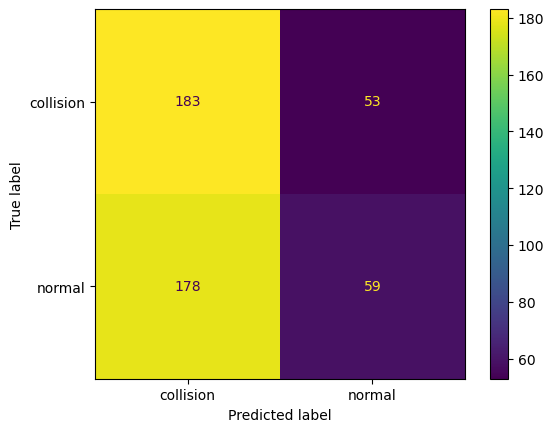

In [46]:
print(inf_matched_report)
cm_inf_matched.plot()

### Test inference data with only camera subset

When using the camera subset from the inference data, we see that the model performance is on par with the test data.

In [47]:
df_inf_camera = df_inf[df_inf['sensor_source'] == 'camera']
labels_inf_camera  = labels_inf[labels_inf['sample_id'].isin(df_inf_camera['sample_id'])]
df_inf_camera_labeled = df_inf_camera.merge(labels_inf_camera, on='sample_id', how='left')

df_inf_camera_labeled_preds = model.predict(df_inf_camera_labeled[features])
df_inf_camera_labeled_probs = model.predict_proba(df_inf_camera_labeled[features])

In [48]:
inf_camera_report, cm_inf_camera = plot_model_eval(df_inf_camera_labeled['label'],
                                                   df_inf_camera_labeled_preds,
                                                   df_inf_camera_labeled_probs)

              precision    recall  f1-score   support

   collision       1.00      0.88      0.94        85
      normal       0.89      1.00      0.94        79

    accuracy                           0.94       164
   macro avg       0.94      0.94      0.94       164
weighted avg       0.95      0.94      0.94       164



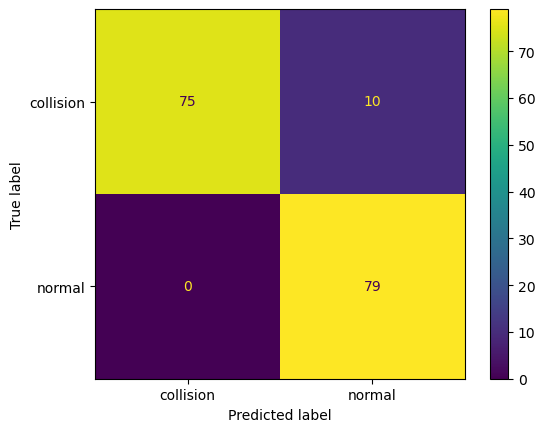

In [49]:
print(inf_camera_report)
cm_inf_camera.plot()

### Retrain with a subset from inference

Alternative approach: fine tune the model with samples from the inference data

In [50]:
_df_inf_new, new_probs, new_model = retrain_model_with_subset(df_train, df_inf, labels_inf,  model, features, 0.1)

##### Model metrics

In [51]:
inf_retrained_report, cm_inf_retrained = plot_model_eval(_df_inf_new['label'], _df_inf_new['pred'], new_probs)

              precision    recall  f1-score   support

   collision       0.66      0.62      0.64       213
      normal       0.64      0.68      0.66       213

    accuracy                           0.65       426
   macro avg       0.65      0.65      0.65       426
weighted avg       0.65      0.65      0.65       426



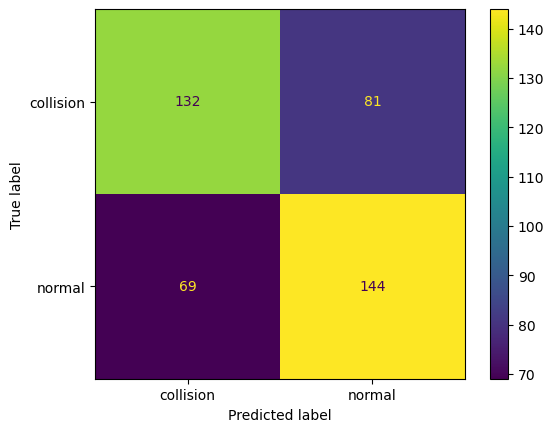

In [52]:
print(inf_retrained_report)
cm_inf_retrained.plot()

### Summary table for the inference data fix analysis

In [53]:
data = {
    'subset': [
        'test', 'test',
        'inf', 'inf',
        'inf_scaled', 'inf_scaled',
        'inf_hist', 'inf_hist',
        'inf_camera', 'inf_camera',
        'inf_fine_tune', 'inf_fine_tune'
    ],
    'index': [
        'collision', 'normal',
        'collision', 'normal',
        'collision', 'normal',
        'collision', 'normal',
        'collision', 'normal',
        'collision', 'normal'
    ],
    'f1_score': [
        0.94, 0.95,
        0.63, 0.29,
        0.67, 0.00,
        0.61, 0.34,
        0.94, 0.94,
        0.64, 0.66
    ],
    'accuracy': [
        0.94, 0.94,
        0.51, 0.51,
        0.50, 0.50,
        0.51, 0.51,
        0.94, 0.94,
        0.65, 0.65
    ]
}

df_summary_fix = pd.DataFrame(data)
df_summary_fix = df_summary_fix.style.background_gradient(cmap='RdYlGn', subset=['f1_score', 'accuracy'])

We can see that the overall best preformance is when we use the subset of the inference that has only camera data source.

In [54]:
df_summary_fix

,subset,index,f1_score,accuracy
0,test,collision,0.940000,0.940000
1,test,normal,0.950000,0.940000
2,inf,collision,0.630000,0.510000
3,inf,normal,0.290000,0.510000
4,inf_scaled,collision,0.670000,0.500000
5,inf_scaled,normal,0.000000,0.500000
6,inf_hist,collision,0.610000,0.510000
7,inf_hist,normal,0.340000,0.510000
8,inf_camera,collision,0.940000,0.940000
9,inf_camera,normal,0.940000,0.940000


# Questions

## From the Github

### Suggest an immediate workaround?

One of the major differences is that the inference data includes data sources from a phone in addition to the camera, whereas the train/test data is exclusively from the camera. It might be that the phone's IMU performs differently than the camera’s, which could cause differences in signal scale and alter the extracted features. This may lead to worse performance of the model on the inference data.
Another major factor is the signal quality. When using the signal viewer, the data in the inference set appears very noisy, which is not the case in the train/test data. it might be due to the diffrent sources as well.

While in the analysis process I wasn’t entirely sure it was all due to the different data types (in hindsight, it seems to be the case), we should explore the features themselves. It appears that the features in the inference dataset haven’t been normalized like those in the train/test datasets (phone type). By reviewing the histograms, summary table, and bar plots for several features, we can observe this pattern.

For example, when looking at the value ranges for the mean features (x_mean, y_mean, z_mean), the ranges in the inference dataset are several magnitudes larger than those in the train/test datasets.

The same pattern can be observed in features like mean, min, max, std, range, energy, fft_max, fft_mean, mag, and max_delta_mag.

Meanwhile, features such as skew, kurtosis, n_peaks, sudden_change_score, and corr in the inference dataset appear to be on a similar scale to the train/test datasets and do not seem to require further preprocessing.

Immediate Workarounds

Hypothesis 1 — Scale Shift (section: 5.6.1):

Scale the unnormalized features in the inference dataset to match the ranges in the train/test datasets.
This yielded F1 scores of 0.67 and 0.00 for the collision and normal classes, respectively, and an accuracy of 0.50 — which is worse than the baseline inference performance (0.63, 0.29, accuracy: 0.51).
This outcome aligns with expectations, as Random Forest models are generally not sensitive to scale shifts. Still, this test was useful to rule out scaling as the main issue.

Hypothesis 2 — Distribution Shift (section: 5.6.2):

Match the histograms of the inference features to those of the training features to account for potential distribution shifts that may be causing degraded model performance.
This yielded F1 scores of 0.61 and 0.34 for the collision and normal classes, with an overall accuracy of 0.61.
This is slightly better than the inference-as-standalone scores (0.63, 0.29, accuracy: 0.51) but still significantly worse than the performance on the test set (0.94, 0.95, accuracy: 0.94).
So, this suggests that distribution shift alone may not be the root cause, leading us to Hypothesis 3.


Hypothesis 3 – Predict Only on the Camera Subset of the Inference Data (Section 5.6.3):

After trying two methods to salvage the entire inference dataset, we see that the results are not good compared to the test set.
To test our hypothesis that the data source is the core problem, we isolate the subset of the inference data that comes only from the camera, then predict and evaluate.
We observe F1 scores of 0.94 and 0.94 for the collision and normal classes, respectively, with an overall accuracy of 0.94, which is nearly identical to the test set results (0.94, 0.95, accuracy: 0.94).
This strongly suggests that the issue with the inference data lies in the data source.


Hypothesis 4 — Inference Data from a New Domain Not Sampled in Train/Test (section: 5.6.4):

As a last ditch effort, we can try fine tuning the model with examples from both the camera and the phone to see if we can salvage some of the phone type data by incorporating it into the training process.
Under this assumption, we fine-tune the model by augmenting the training set with a small, balanced sample (10%) of the inference data, that include sample based on the sensor source and the label.
We ensure the class balance matches that of the train/test data, retrain the model, and evaluate it on the remaining (untouched) inference data.
This approach yielded F1 scores of 0.64 and 0.66 for the collision and normal classes, respectively, with an accuracy of 0.65.
This is an improvement over Hypotheses 1 and 2 and helps correct the class imbalance seen in predictions for the normal class.
However, it still falls short of the performance seen on the test set (0.94, 0.95, accuracy: 0.94).

Summary

The analysis highlights that the model's poor performance on inference data is primarily due to a domain shift introduced by the inclusion of phone-based IMU signals, whereas the train/test data only contain camera-based signals. The phone IMU appears to produce noisier and differently scaled signals, which significantly affect feature distributions particularly for key features like mean, energy, and frequency while some statistical features remain consistent. Initial hypotheses focused on scale and distribution shifts showed limited improvement, confirming that Random Forest is not very sensitive to scaling and that distribution matching alone cannot resolve the issue. However, when filtering the inference data to include only camera based samples, model performance nearly matched the test set, strongly suggesting that the phone IMU is the root cause. A final attempt to fine tune the model using a small, stratified sample from both sensor types showed moderate improvement, but still fell short of the original performance, reinforcing the need to either preprocess phone data appropriately or retrain the model with a more representative dataset.

Please see analysis in sections 5.6 and onwords.

### Propose a long-term fix?

A long term fix involves redesigning the data pipeline and model training strategy to ensure robustness across all relevant domains.

First, the process_dataset and extract_features functions must be updated to detect the data source (e.g., phone vs. camera) and apply appropriate preprocessing steps, including noise filtering and normalization specific to each sensor type. A standard, consistent preprocessing pipeline should be implemented and enforced across all datasets to minimize scale and quality discrepancies.

Second, the training dataset must be expanded to include diverse samples across all domain variables such as sensor types, IMU models, signal quality levels, vehicle types, and driver behaviors to ensure the model generalizes well. This may involve collecting more labeled phone based IMU data or simulating it under controlled conditions.

## Additional questions

## ❓ Questions to Reflect On


- What do you observe when comparing the model’s predictions on the new data to its known performance?

- Is there anything in the data that might explain differences in behavior?

- Can you identify patterns or trends related to when the model succeeds or fails?

- Are there signals or features that seem to affect the model’s reliability?

- What could be done in the short term to handle the current situation?

- What are potential long-term steps to improve model performance in similar scenarios?

- What would you want to explore further if given more time or data?

- What assumptions did the model rely on during training — and are they still valid?

- Q: What do you observe when comparing the model’s predictions on the new data to its known performance?

- A: As described in more detail in section 5.6.1, we observe much lower performance as reflected in the F1 scores and overall accuracy. Specifically, the score for the Normal class is much lower than for the Collision class, indicating that the model, when applied to the inference data, is drastically underperforming on the Normal class.

- Q: Is there anything in the data that might explain differences in behavior?

- A: The samples based on labels seem to be balanced, while the sensor_source in the inference data is mixed, containing both phone and camera IMU signals. another thing is the signal quality, the inference data is much more noisey than the train/test. Additionally, the scaling of the features especially the strongest ones differs from the train/test data. It almost seems like they were not processed or preprocessed in the same way as the train/test data.

- Q: Can you identify patterns or trends related to when the model succeeds or fails?

- A: When the data is predicted using only the camera sensor_source, and there is no noise in the signal it succeeds as in the test set. However, when we introduce data from the phone type which is noisy, it fails. If we introduce a small sample from the phone source into the training data and fine tune the model, we start to see improved performance.

- Q:Are there signals or features that seem to affect the model’s reliability?

- A: There is significant noise in the XYZ axes in the phone subset of the inference data. We know that the strongest features are based on the Y-axis in the IMU energy, magnitude, and frequency. Since these features are derived from the IMU, the noise propagates into them. We need to investigate whether different preprocessing steps or even differences in the signal source could be drastically affecting the features and, consequently, the model’s performance.

- Q: What could be done in the short term to handle the current situation?

- A: As described in more detail in Section 5.6.1, we can try scaling the inference features to match the training feature scales. We can also apply histogram matching to better align with the training domain. Lastly, we can fine tune the model using a stratified sample based on both sensor_source and label. Additionally, we can apply a filter to the noisy signal and try to correct this noise in the raw data. However, I believe this needs to be implemented within the extract_features function. eventully the best approch is to use the subset of the inference that is from the camera source only.

- Q: What are potential long-term steps to improve model performance in similar scenarios?

- A: We need to ensure that the data is processed consistently during training, and that our training set provides full representation across key domains such as sensor sources, IMU accuracy, driver types, etc. We also need to dive into the extract_features function to check if anything went wrong or if a preprocessing step is missing.

- Q: What would you want to explore further if given more time or data?

- A: To understand why the performance decreases when phone IMU data is introduced, we need many more phone data samples to create a sufficiently large training set. Is the noise related to a certain phone type or IMU model? Which filters should we use to smooth the signal? We also need to develop a common processing method for these signals that accounts for nuances and accuracy in the XYZ axes.

- Q: What assumptions did the model rely on during training — and are they still valid?

- A: The model is based only on samples from the camera and not on phone samples. Currently, this is not valid because real world data contains a large amount of IMU data from phones, which is noisy and needs to be processed differently.